In [7]:
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import sklearn, scipy

from minisom import MiniSom

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans

from colour import Color
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

import pandas as pd
import gin
import seaborn as sns

In [145]:
gin.enter_interactive_mode()

In [9]:
df_pivot = pd.read_csv('../../results/pairs_win_rate_player_1_pbt_1adv.csv', index_col=0)

In [153]:
df_pivot_norm = pd.DataFrame(sklearn.preprocessing.normalize(df_pivot))
df_pivot_norm.index = df_pivot.index
df_pivot_norm.columns = df_pivot.columns

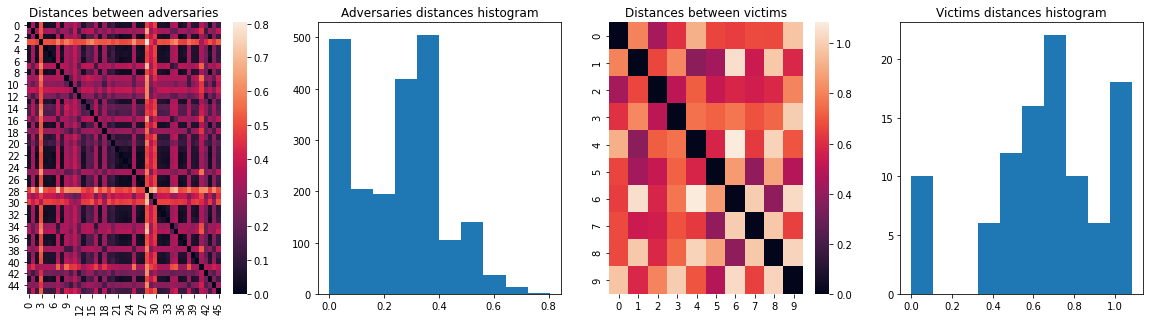

In [159]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.title("Distances between adversaries")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm, df_pivot_norm)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 2)
plt.title("Adversaries distances histogram")
plt.hist(dist_pairs.flatten())

plt.subplot(1, 4, 3)
plt.title("Distances between victims")
dist_pairs = scipy.spatial.distance.cdist(df_pivot_norm.T, df_pivot_norm.T)
sns.heatmap(dist_pairs)

plt.subplot(1, 4, 4)
plt.title("Victims distances histogram")
plt.hist(dist_pairs.flatten())
plt.show()

In [211]:
assert df_pivot.index[0][0] == 'a'
assert df_pivot.columns[0][0] == 'v'

In [212]:
PCA = gin.external_configurable(PCA)
KMeans = gin.external_configurable(KMeans)

In [223]:
@gin.configurable
def cluster_vectors(method, vectors, visual_method=None, names=None, plot=False):
    """Cluster input vectors using a method."""
    m = method()
    out = m.fit_transform(vectors)
    n_clusters = len(m.cluster_centers_)
    clusters = range(n_clusters)
    n_data = len(vectors)
    dist_vec_cluster = scipy.spatial.distance.cdist(vectors, m.cluster_centers_)
    items_in_cluster = {cluster: [i for i in range(n_data) if m.labels_[i] == cluster]
                        for cluster in range(n_clusters)}
#     print(items_in_cluster)
    
    closest_to_center = [np.argmin([dist_vec_cluster[v, c] for v in items_in_cluster[c]]) for c in clusters]
    closest_to_center = [items_in_cluster[c][closest_idx] for closest_idx, c in zip(closest_to_center, clusters)]
#     print(closest_to_center)

    names_aggregate = [' '.join([names[i] for i in items_in_cluster[c]]) for c in clusters]
    
#     print(names_aggregate)
    
    # showing the visualization
    if plot and visual_method is not None:
        assert len(vectors) == len(names)
        vis = visual_method(n_components=2)
        v_pca = vis.fit_transform(vectors)
        plt.figure(figsize=(10, 5))
        plt.title(f"Clustering with {method.__name__}, {n_clusters} clusters, {visual_method.__name__} space")
        plt.scatter(v_pca[:, 0], v_pca[:, 1], c=m.labels_)
        for i in range(n_data):
            plt.text(x=v_pca[i, 0], y=v_pca[i, 1], s=names[i])
            
        c_pca = vis.transform(m.cluster_centers_)
        plt.scatter(c_pca[:, 0], c_pca[:, 1], c=clusters, s=150)
        for c in clusters:
            closest_idx = closest_to_center[c]
            plt.scatter(*v_pca[closest_idx, :], marker='2', c=c, s=150)
        
        plt.show()
    
    return {'labels': m.labels_,
            'clusters': m.cluster_centers_,
            'closest_to_center': closest_to_center,
            'names': names_aggregate}

In [224]:
gin.bind_parameter("KMeans.n_clusters", 5)
gin.bind_parameter("cluster_vectors.method", KMeans)
gin.bind_parameter("cluster_vectors.visual_method", PCA)

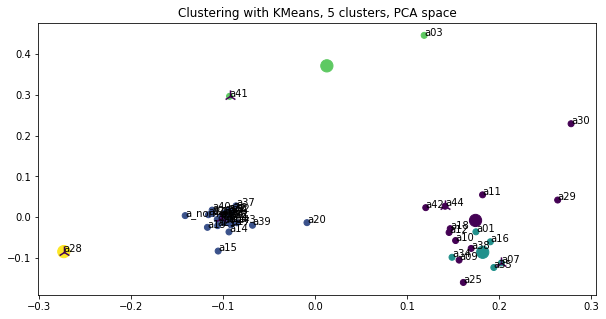

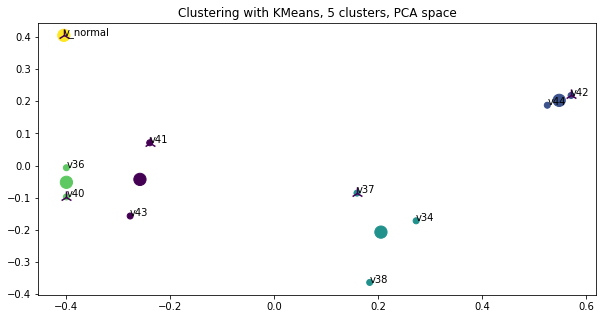

In [225]:
clustered_adversaries = cluster_vectors(vectors=df_pivot_norm, plot=True, names=df_pivot.index)
clustered_victims = cluster_vectors(vectors=df_pivot_norm.T, plot=True, names=df_pivot.columns)

In [226]:
clustered_victims

{'labels': array([2, 3, 2, 2, 3, 0, 1, 0, 1, 4], dtype=int32),
 'clusters': array([[0.30681364, 0.27566935, 0.30845441, 0.22008163, 0.33064233,
         0.32685264, 0.31610353, 0.2823604 , 0.31679446, 0.2544847 ,
         0.26635588, 0.12641173, 0.26005153, 0.30893782, 0.26842648,
         0.3214889 , 0.23193408, 0.32706004, 0.22914491, 0.34421549,
         0.31115816, 0.32779029, 0.31168222, 0.32180471, 0.31811706,
         0.21264566, 0.31785248, 0.31804223, 0.17278961, 0.15412656,
         0.14626396, 0.32342901, 0.33055099, 0.32046492, 0.27599253,
         0.25680134, 0.31745172, 0.32399126, 0.23154117, 0.32007141,
         0.31916986, 0.26614966, 0.27168564, 0.31323881, 0.26654972,
         0.34431818],
        [0.31733296, 0.4070931 , 0.32559077, 0.49518366, 0.31700759,
         0.31583514, 0.32290145, 0.39595366, 0.32027571, 0.38778621,
         0.41679762, 0.471171  , 0.41897192, 0.31990603, 0.32396299,
         0.3015516 , 0.41077481, 0.3213555 , 0.45065166, 0.32448339,
      

In [250]:
df_clustered = df_pivot.iloc[clustered_adversaries['closest_to_center'], clustered_victims['closest_to_center']].copy()
df_clustered.index = clustered_adversaries['names']
df_clustered.columns = clustered_victims['names']
df_clustered

,v41 v43,v42 v44,v34 v37 v38,v36 v40,v_normal
a09 a10 a11 a12 a18 a25 a29 a30 a38 a42 a44,55.0,80.0,67.0,45.0,44.0
a00 a02 a04 a05 a06 a08 a13 a14 a15 a17 a19 a20 a21 a22 a23 a24 a26 a27 a31 a32 a33 a36 a37 a39 a40 a43 a_normal,91.0,89.0,94.0,87.0,87.0
a01 a07 a16 a34 a35,43.0,64.0,51.0,23.0,15.0
a03 a41,21.0,25.0,21.0,16.0,25.0
a28,13.0,11.0,12.0,32.0,7.0


In [284]:
m = cols[0].range_to

In [285]:
?m

Signature: m(value, steps)
Docstring: <no docstring>
File:      /scratch/sergei/miniconda3/lib/python3.7/site-packages/colour.py
Type:      method


In [277]:
cols = list(Color("white").range_to("blue", 20))

In [278]:
c.get_web()

'white'

In [279]:
from IPython.display import HTML as html_print

def cstr(color='black'):
    return f"""<svg width="20" height="20"><rect width="20" height="20" style="fill:{color};stroke-width:3;stroke:rgb(0,0,0)" /></svg>""".format(color)

colors = cols
html_print(''.join([cstr(c) for c in colors]) + '<span></span>')

In [ ]:
def plot_df_as_graph(df):
    n_colors = 100
    adv_win_color = list(Color("white").range_to("red", n_colors))
    vct_win_color = list(Color("white").range_to("blue", n_colors))

    def closest(frac, colors):
        """Closest color to a fraction."""
        closest_idx = np.argmin(np.abs(np.linspace(0, 1, n_colors) - frac))
        return colors[closest_idx].get_hex_l()

    edges_lst = []
    edge_strength = []
    edge_color = []

    # eng="circo"
    # eng="neato"
    eng=None
    ps = Digraph(name='Win model', engine=eng, graph_attr=dict(nodesep="0.1"), node_attr={"nodesep": ".1", "overlap":"true"})
    # node_attr={'shape': 'plaintext'})

    for f in df.columns:
        ps.node(f, color='blue')
    for f in df.index:
        ps.node(f, color='red')

    # adding edges
    edges = 0

    for p2 in df.columns:
        for p1 in df.index:
            val = df.loc[p1, p2]

            v1v2 = [p1, p2]

            maxwidth = 5
            strength = abs(val - 50) / 50
            width = maxwidth * strength


            # val > 50 means that player 1 (adversary) wins
            # arrow goes FROM the winning player
            if val > 50:
                label = None#str(round(val))
                color = closest(strength, adv_win_color)
                ps.edge(*v1v2, label=label, penwidth=str(width), color=color, len=".1")
                edges_lst.append(v1v2)
                edge_strength.append(strength)
                edge_color.append(color)
                edges += 1
            else:
                label = None#str(round(val))
                color = closest(strength, vct_win_color)
                ps.edge(*v1v2[::-1], label=label, penwidth=str(width), color=color, len=".1")
                edge_strength.append(strength)
                edge_color.append(color)
                edges_lst.append(v1v2[::-1])
                edges += 1

    max_edges = len(df.index) * len(df.columns)
    percent = int(100 - 100. * edges / max_edges)
    print("Number of edges: %d out of %d, sparsity %.2f%%" % \
          (edges, max_edges, percent))

    # f_out = f"CausalModel"
    # ps.render(filename=f_out, format='png')
    
    allnodes = [v for e in edges_lst for v in e]

    # Create Directed Graph
    G=nx.DiGraph()

    # Add a list of nodes:
    G.add_nodes_from(allnodes)

    # Add a list of edges:
    G.add_edges_from(edges_lst)


    return ps, G

Number of edges: 25 out of 25, sparsity 0.00%


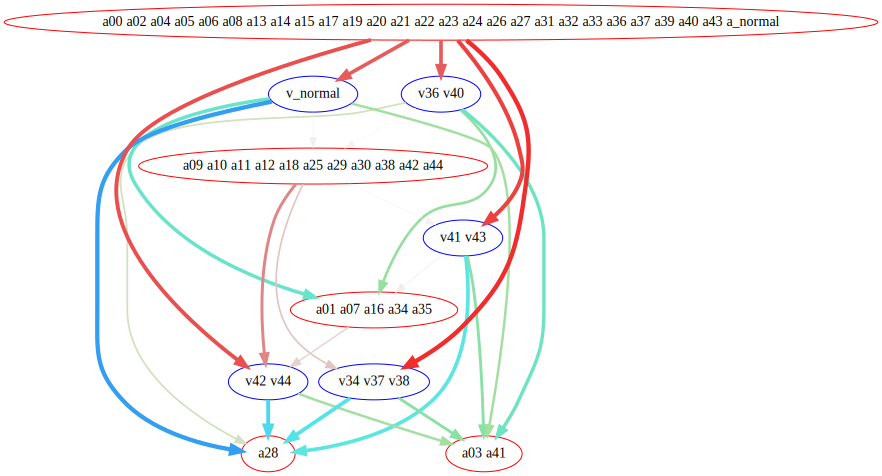

In [241]:
ps, G = plot_df_as_graph(df_clustered)
ps

In [242]:
def strength_for_cycle(cycle):
    strengths = []
#     cycle = cycle + [cycle[0]]
    for i in range(len(cycle) - 1):
        v1, v2 = cycle[i:i+2]
        e_idx = edges_lst.index([v1, v2])
        strength = edge_strength[e_idx]
        strengths.append(strength)
    return strengths

cycles = list(nx.simple_cycles(G))
cycles = [cycle + [cycle[0]] for cycle in cycles]
    
#Return a list of cycles described as a list o nodes
strengths = [strength_for_cycle(cycle) for cycle in cycles]
min_strength = [min(x) for x in strengths]

data = []
for idx in np.argsort(min_strength)[::-1]:
    data.append(dict(cycle=cycles[idx], edge_strength=strengths[idx], min_stength_percent=min_strength[idx] * 100))
pd.DataFrame(data)

""


In [245]:
pos = nx.layout.spring_layout(G)

node_sizes = [3 for i in range(len(G))]
M = G.number_of_edges()
# edge_colors = edge_color
edge_alphas = (np.array(edge_strength) - np.min(edge_strength)) / (np.max(edge_strength) - np.min(edge_strength))#[(5 + i) / (M + 4) for i in range(M)]

plt.figure(figsize=(10, 10))


nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="blue")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
# plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()


NameError: name 'edge_strength' is not defined

In [425]:
edge_strength

[4.2,
 1.2,
 4.699999999999999,
 2.6,
 4.5,
 3.8,
 4.5,
 2.8000000000000003,
 4.0,
 4.4,
 2.2,
 4.699999999999999,
 2.7,
 4.2,
 4.0,
 4.2,
 2.1,
 4.4,
 3.8,
 0.5,
 4.1,
 3.1,
 4.3,
 3.2,
 4.6000000000000005,
 0.1,
 4.3,
 4.5,
 0.1,
 3.9000000000000004,
 4.0,
 4.4,
 3.7,
 3.9000000000000004,
 0.3,
 4.2,
 4.1,
 2.0,
 4.0,
 3.4000000000000004,
 3.7,
 3.5,
 4.4,
 2.7,
 3.7,
 3.4000000000000004,
 0.4,
 4.3,
 1.7000000000000002,
 4.6000000000000005,
 4.3,
 4.4,
 0.7000000000000001,
 4.0,
 3.5999999999999996,
 3.1,
 4.4,
 0.6,
 4.1,
 3.2,
 4.4,
 1.4000000000000001,
 4.4,
 4.1,
 1.0,
 3.7,
 3.5,
 4.8,
 3.5,
 4.2,
 0.6,
 4.2,
 4.5,
 0.4,
 4.6000000000000005,
 0.2,
 4.5,
 4.0,
 4.6000000000000005,
 0.8,
 4.0,
 3.5,
 2.2,
 3.8,
 0.4,
 3.5999999999999996,
 2.8000000000000003,
 3.8,
 3.5,
 3.5999999999999996]